# 필요 패키지 설치

In [1]:
# jupyter notebook cell 너비 조절
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

import warnings
warnings.filterwarnings("ignore")

In [2]:
# 기본
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import joblib 
from sklearn.metrics import make_scorer

# 시계열
from fbprophet import Prophet
from datetime import datetime as dt
from statsmodels.tsa.arima_model import ARIMA
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing

# 회귀분석
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

# Deep Neural Network
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import time

# 설정
%matplotlib inline
pd.options.display.max_columns = 400
pd.options.display.float_format = '{:.5f}'.format

# 평가 지표 : MAE (절댓값 오차의 평균)

In [3]:
def mae(prediction, correct):
    prediction = np.array(prediction)
    correct = np.array(correct)
    
    difference = correct - prediction
    abs_val = abs(difference)
    score = abs_val.mean()
    
    return score

# # Step1. Data Load

# 데이터 불러오기

In [4]:
df_train = pd.read_csv('C:/Users/user/Desktop/data09/funda_train.csv', encoding='utf-8')
df_sub = pd.read_csv('C:/Users/user/Desktop/data09/submission.csv', encoding='utf-8')

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6556613 entries, 0 to 6556612
Data columns (total 9 columns):
 #   Column            Dtype  
---  ------            -----  
 0   store_id          int64  
 1   card_id           int64  
 2   card_company      object 
 3   transacted_date   object 
 4   transacted_time   object 
 5   installment_term  int64  
 6   region            object 
 7   type_of_business  object 
 8   amount            float64
dtypes: float64(1), int64(3), object(5)
memory usage: 450.2+ MB


In [6]:
frame_info = []
for col in df_train.columns:
    # column, column unique 길이, column null 갯수, column 데이터 형태, column 데이터
    frame_info.append([col, len(df_train[col].unique()), df_train[col].isnull().sum(), df_train[col].dtype, df_train[col].unique()[:5]])

# frame_info를 dataframe 형태로 변환
df_info = pd.DataFrame(frame_info, columns=['name', 'num_of_unique', 'num_of_nan', 'dtype', 'front5_values'])
df_info

,name,num_of_unique,num_of_nan,dtype,front5_values
0,store_id,1967,0,int64,"[0, 1, 2, 4, 5]"
1,card_id,3950001,0,int64,"[0, 1, 2, 3, 4]"
2,card_company,8,0,object,"[b, h, c, a, f]"
3,transacted_date,1003,0,object,"[2016-06-01, 2016-06-02, 2016-06-03, 2016-06-0..."
4,transacted_time,1440,0,object,"[13:13, 18:12, 18:52, 20:22, 11:06]"
5,installment_term,34,0,int64,"[0, 2, 3, 60, 4]"
6,region,181,2042766,object,"[nan, 서울 종로구, 충북 충주시, 부산 동래구, 경기 평택시]"
7,type_of_business,146,3952609,object,"[기타 미용업, nan, 의복 액세서리 및 모조 장신구 도매업, 한식 음식점업, 배..."
8,amount,30551,0,float64,"[1857.142857142857, 857.1428571428571, 2000.0,..."


# 시계열 분석을 위해 date 정보를 index로 변환

In [7]:
# transacted_date 형태를 datetime으로 변경
df_train['transacted_date'] = pd.to_datetime(df_train['transacted_date'], format='%Y-%m-%d')

# tansacted_date를 index로 설정
df_train = df_train.set_index('transacted_date')
df_train.head(10)

,store_id,card_id,card_company,transacted_time,installment_term,region,type_of_business,amount
transacted_date,,,,,,,,
2016-06-01,0,0,b,13:13,0,NaN,기타 미용업,1857.14286
2016-06-01,0,1,h,18:12,0,NaN,기타 미용업,857.14286
2016-06-01,0,2,c,18:52,0,NaN,기타 미용업,2000.00000
2016-06-01,0,3,a,20:22,0,NaN,기타 미용업,7857.14286
2016-06-02,0,4,c,11:06,0,NaN,기타 미용업,2000.00000
2016-06-02,0,5,c,13:09,0,NaN,기타 미용업,2000.00000
2016-06-02,0,6,f,15:33,0,NaN,기타 미용업,2000.00000
2016-06-02,0,7,a,17:18,0,NaN,기타 미용업,7857.14286
2016-06-02,0,8,c,18:30,0,NaN,기타 미용업,2000.00000


# 시간 단위로 나뉘어져 있는 데이터를 일단위로 resampling
- 'store_id', 'region', 'type_of_business' 기존과 동일
- day_of_week : 요일을 나타내는 숫자, 월요일은 0 일요일은 6
- business_day : working day 여부, 월~금 : 1,  토~일 : 0
- num_of_pay : 일 결제 건수
- num_of_revisit : 단골 방문 횟수, 'card_id'의 value 중 count가 3 이상이면 단골
- installment_term : 일 총 할부 개월 수, 기존 installment_term의 합
- amount : 일 매출 액, 기존 amount의 합

In [8]:
def resample_day(train_df):
    df_day = pd.DataFrame()
    for i in train_df.store_id.unique():
        df_num = train_df[train_df.store_id == i]
        
        # 'card_id' 의 일별 counting을 통해 일 거래 횟수 확인
        # resample 메소드의 활용 : rule='d'는 하루 단위로 구간 설정
        count_cols = df_num.card_id.resample('1D').count().rename('num_of_pay')
        
        # 'card_id' value count가 2보다 크면 단골인 것으로 판단하고 단골 card_id 추출
        revisit_idx = df_num.card_id.value_counts().reset_index().query("card_id > 2")["index"].values 
        revisit_ct = df_num[df_num.card_id.isin(revisit_idx)].card_id.resample('1D').count().rename('num_of_revisit')
        
        sum_cols = df_num[['installment_term', 'amount']].resample('1D').sum() # 할부 개월수와 매출액은 일 단위로 합
        
        df_num_day = pd.concat([count_cols, revisit_ct, sum_cols], axis=1)
        df_num_day.insert(0, 'store_id', i)
        df_num_day.insert(4, 'region', df_num[df_num.store_id == i].region.unique()[0])
        df_num_day.insert(5, 'type_of_business', df_num[df_num.store_id == i].type_of_business.unique()[0])
        df_day = pd.concat([df_day, df_num_day], axis=0)
        
        
    df_day.insert(1, 'day_of_week', df_day.index.dayofweek)
    df_day.insert(2, 'business_day', df_day.day_of_week.replace({0:1, 2:1, 3:1, 4:1, 5:0, 6:0}).values)
    
    # 일 단골 결제 횟수가 없다면 0으로 채워주기
    df_day.num_of_revisit.fillna(0, inplace=True)
    
    return df_day

In [9]:
df_day = resample_day(df_train)
df_day.head(10)

,store_id,day_of_week,business_day,num_of_pay,num_of_revisit,installment_term,region,type_of_business,amount
transacted_date,,,,,,,,,
2016-06-01,0,2,1,4,4.00000,0,NaN,기타 미용업,12571.42857
2016-06-02,0,3,1,7,3.00000,0,NaN,기타 미용업,40571.42857
2016-06-03,0,4,1,3,2.00000,0,NaN,기타 미용업,18142.85714
2016-06-04,0,5,0,7,3.00000,0,NaN,기타 미용업,31714.28571
2016-06-05,0,6,0,3,3.00000,0,NaN,기타 미용업,10428.57143
2016-06-06,0,0,1,4,2.00000,0,NaN,기타 미용업,17285.71429
2016-06-07,0,1,1,0,0.00000,0,NaN,기타 미용업,0.00000
2016-06-08,0,2,1,0,0.00000,0,NaN,기타 미용업,0.00000
2016-06-09,0,3,1,9,5.00000,0,NaN,기타 미용업,35000.00000


# 각 컬럼간 상관관계 확인

In [10]:
daily_corr = df_day.corr()
daily_corr

,store_id,day_of_week,business_day,num_of_pay,num_of_revisit,installment_term,amount
store_id,1.00000,-0.00004,0.00001,0.04237,0.00806,-0.01218,-0.01835
day_of_week,-0.00004,1.00000,-0.79052,0.01672,-0.03869,-0.01395,-0.02150
business_day,0.00001,-0.79052,1.00000,-0.00460,0.05721,0.01530,0.02947
num_of_pay,0.04237,0.01672,-0.00460,1.00000,0.70112,0.09414,0.26525
num_of_revisit,0.00806,-0.03869,0.05721,0.70112,1.00000,0.07113,0.26067
installment_term,-0.01218,-0.01395,0.01530,0.09414,0.07113,1.00000,0.26750
amount,-0.01835,-0.02150,0.02947,0.26525,0.26067,0.26750,1.00000


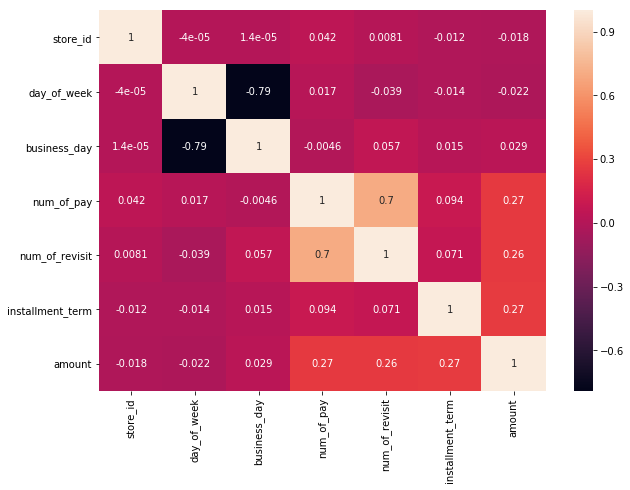

In [11]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 7)
sns.heatmap(daily_corr, annot=True)

# Modeling 위해 Month 단위로 resampling

In [12]:
def resample_month(frame_day):
    sum_cols = ['num_of_pay', 'num_of_revisit', 'installment_term', 'amount']

    df_monthly = pd.DataFrame()

    for i in frame_day.store_id.unique():
        df_set = frame_day[frame_day.store_id == i]
        
        # nan값이 발생하는 경우를 없애기 위해 이전, 이후 달에 대한 정보를 추가한 후 제거
        prev_date = pd.date_range(start=(df_set.index[0] - relativedelta(months=1)), end=(df_set.index[0] - relativedelta(months=1)))
        add_date = pd.date_range(start=(df_set.index[-1] + relativedelta(months=1)), end=(df_set.index[-1] + relativedelta(months=1)))
        df_set = pd.concat([pd.DataFrame(index=prev_date), df_set, pd.DataFrame(index=add_date)], axis=0)

        df_set.iloc[0] = 1
        df_set.iloc[-1] = 1
        
        # 한달 전체 거래 일 수
        tot_day = df_set[df_set.amount != 0].business_day.resample('1M').count().rename('real_tot_day')
        # 한달 거래 중 business 일 수
        business = df_set[df_set.amount != 0].business_day.resample('1M').sum().rename('real_business_day')

        business = business.drop([business.index[0], business.index[-1]], axis=0)
        tot_day = tot_day.drop([tot_day.index[0], tot_day.index[-1]], axis=0)
        df_set = df_set.drop([df_set.index[0], df_set.index[-1]], axis=0)
        df = pd.concat([tot_day, business, df_set[sum_cols].resample('1M').sum()], axis=1)

        df.insert(0, 'store_id', i)
        df.insert(6, 'region', df_set.region.values[0])
        df.insert(7, 'type_of_business', df_set.type_of_business.values[0])

        df_monthly = pd.concat([df_monthly, df], axis=0)
   
    return df_monthly

In [13]:
df_month = resample_month(df_day)
df_month.head(10)

,store_id,real_tot_day,real_business_day,num_of_pay,num_of_revisit,installment_term,region,type_of_business,amount
2016-06-30,0,25,17.00000,145.00000,77.00000,13.00000,NaN,기타 미용업,747000.00000
2016-07-31,0,26,16.00000,178.00000,105.00000,24.00000,NaN,기타 미용업,1005000.00000
2016-08-31,0,24,16.00000,171.00000,97.00000,69.00000,NaN,기타 미용업,871571.42857
2016-09-30,0,25,19.00000,160.00000,103.00000,15.00000,NaN,기타 미용업,897857.14286
2016-10-31,0,26,16.00000,167.00000,115.00000,9.00000,NaN,기타 미용업,835428.57143
2016-11-30,0,23,15.00000,132.00000,93.00000,21.00000,NaN,기타 미용업,697000.00000
2016-12-31,0,27,18.00000,145.00000,103.00000,11.00000,NaN,기타 미용업,761857.14286
2017-01-31,0,20,15.00000,118.00000,81.00000,4.00000,NaN,기타 미용업,585642.85714
2017-02-28,0,23,15.00000,147.00000,97.00000,20.00000,NaN,기타 미용업,794000.00000
2017-03-31,0,23,15.00000,134.00000,97.00000,11.00000,NaN,기타 미용업,720257.14286


In [14]:
df_month.isnull().sum()

store_id                 0
real_tot_day             0
real_business_day        0
num_of_pay               0
num_of_revisit           0
installment_term         0
region               20900
type_of_business     36048
amount                   0
dtype: int64

In [15]:
print("rate of 'region' :" , df_month.region.isnull().sum() / len(df_month))
print("rate of 'type_of_business' :" , df_month.type_of_business.isnull().sum() / len(df_month))

rate of 'region' : 0.34310104243618156
rate of 'type_of_business' : 0.5917754247722236


In [16]:
df_month = df_month.drop(['region', 'type_of_business'], axis=1)
df_month.isnull().sum()

store_id             0
real_tot_day         0
real_business_day    0
num_of_pay           0
num_of_revisit       0
installment_term     0
amount               0
dtype: int64

# # Step2. EDA

# 변수의 describe 확인

In [17]:
df_month.describe()

,store_id,real_tot_day,real_business_day,num_of_pay,num_of_revisit,installment_term,amount
count,60915.00000,60915.00000,60915.00000,60915.00000,60915.00000,60915.00000,60915.00000
mean,1050.48428,21.06987,15.89640,107.63544,40.01136,14.87540,1123187.83063
std,617.48320,7.75327,5.63136,101.24413,43.88133,33.42161,1753567.15171
min,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,-514285.71429
25%,515.00000,16.00000,12.00000,32.00000,11.00000,0.00000,339642.85714
50%,1039.00000,23.00000,17.00000,73.00000,26.00000,3.00000,710714.28571
75%,1587.00000,28.00000,21.00000,159.00000,54.00000,14.00000,1344650.00000
max,2136.00000,31.00000,23.00000,2186.00000,2154.00000,1125.00000,61429316.14286


# target 변수의 분포(대칭성, 정규성) 확인

Skewness : 0.4824551090840082


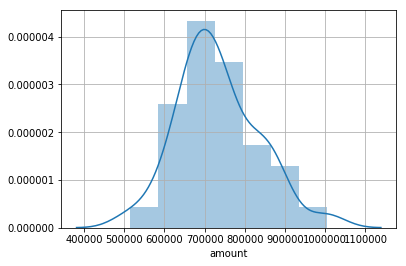

Skewness : 0.5102521050694743


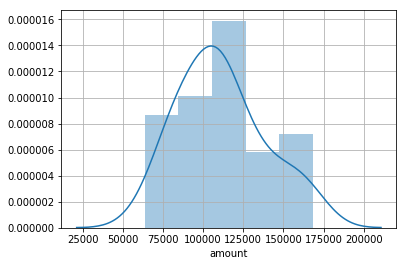

Skewness : 0.9982599271676991


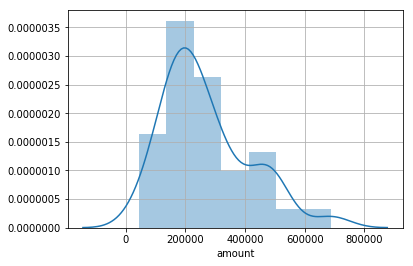

In [18]:
for i in df_month.store_id.unique()[:3]:
    print("Skewness :", df_month[df_month.store_id == i].amount.skew())
    sns.distplot(df_month[df_month.store_id == i].amount)
    plt.grid()
    plt.show()

# store_id 별 target 변수 분포 확인
- 각 store_id별로 다른 trend, seasonality, scale을 가지는 것을 확인할 수 있음

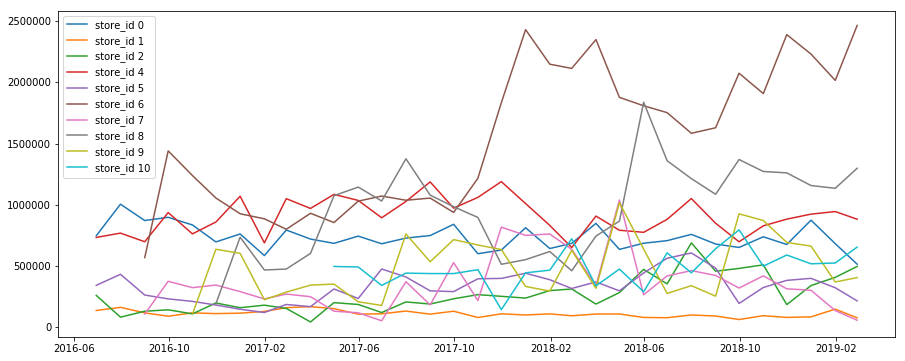

In [19]:
plt.figure(figsize=(15, 6))
for i in df_month.store_id.unique()[:10]:
    plt.plot(df_month[df_month.store_id == i].index, df_month[df_month.store_id == i].amount, label='store_id {}'.format(i))
plt.legend()

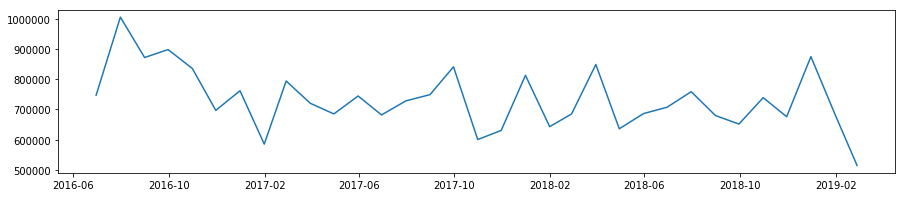

In [20]:
plt.figure(figsize=(15, 3))
plt.plot(df_month[df_month.store_id == 0].index, df_month[df_month.store_id == 0].amount)

# 설명 변수의 분포 확인

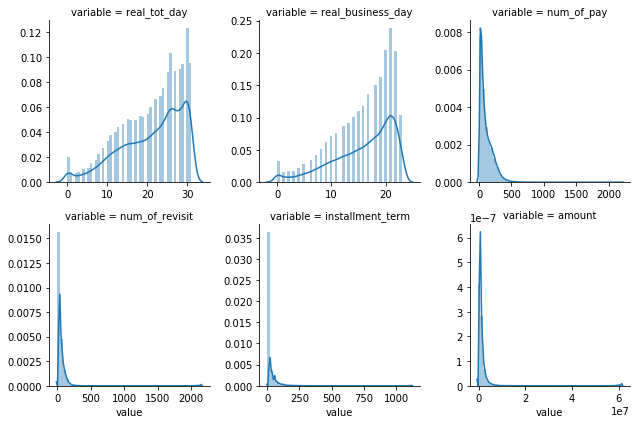

In [21]:
f = pd.melt(df_month, value_vars=df_month.columns[1:])
g = sns.FacetGrid(f, col="variable",  col_wrap=3, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")
plt.show() 

# 각 컬럼간 상관관계 확인

In [22]:
month_corr = df_month.corr()
month_corr

,store_id,real_tot_day,real_business_day,num_of_pay,num_of_revisit,installment_term,amount
store_id,1.00000,0.03736,0.01536,0.05931,0.01114,-0.03182,-0.03842
real_tot_day,0.03736,1.00000,0.94404,0.65909,0.50319,0.08818,0.17780
real_business_day,0.01536,0.94404,1.00000,0.60763,0.50575,0.09916,0.19710
num_of_pay,0.05931,0.65909,0.60763,1.00000,0.74651,0.02628,0.21073
num_of_revisit,0.01114,0.50319,0.50575,0.74651,1.00000,-0.01855,0.17386
installment_term,-0.03182,0.08818,0.09916,0.02628,-0.01855,1.00000,0.40140
amount,-0.03842,0.17780,0.19710,0.21073,0.17386,0.40140,1.00000


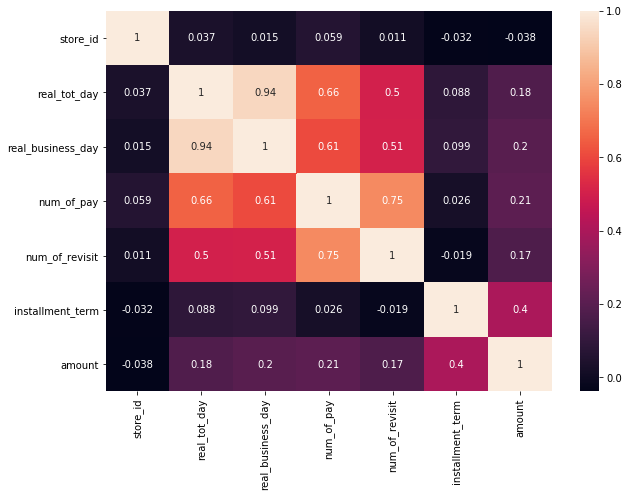

In [23]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 7)
sns.heatmap(month_corr, annot=True)

# 다른변수들이 'amount'와 같은 pattern을 가지는 지 확인

In [24]:
def plot_model_graph(data_frame, store_num, idx_col, y_cols):
    df_set = data_frame[data_frame.store_id == store_num]
    
    fig, ax1 = plt.subplots(figsize=(15, 3))
    ax1.set_xlabel("{}".format(idx_col))
    ax1.set_ylabel("{}".format(y_cols[0])).set_color(color='tab:blue')
    ax1.plot(df_set.index, df_set[y_cols[0]].values, color='tab:blue')
    
    for i in range(1, len(y_cols)):
        ax2 = ax1.twinx()
        ax2.set_ylabel("{}".format(y_cols[i])).set_color(color='C{}'.format(i))
        ax2.plot(df_set.index, df_set[y_cols[i]].values, color='C{}'.format(i))
        ax2.spines['right'].set_position(('outward', (60*(i-1))))

    fig.tight_layout()
    plt.show()

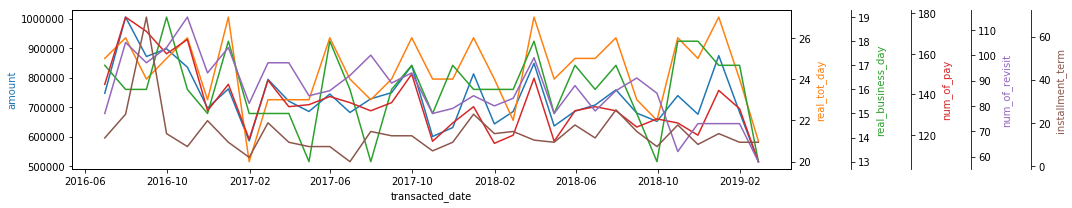

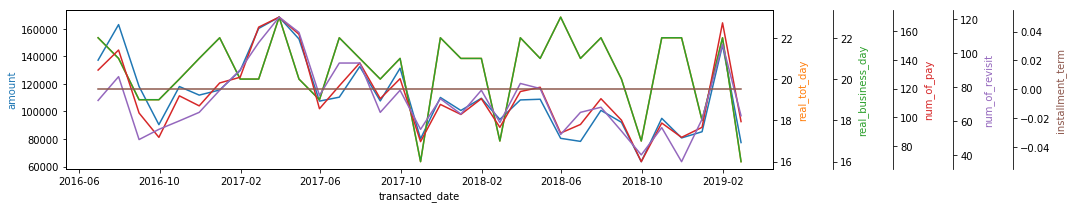

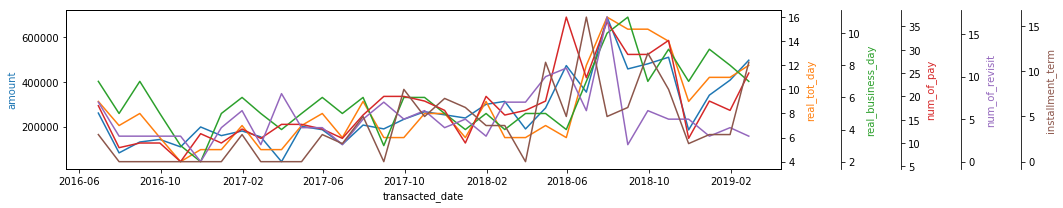

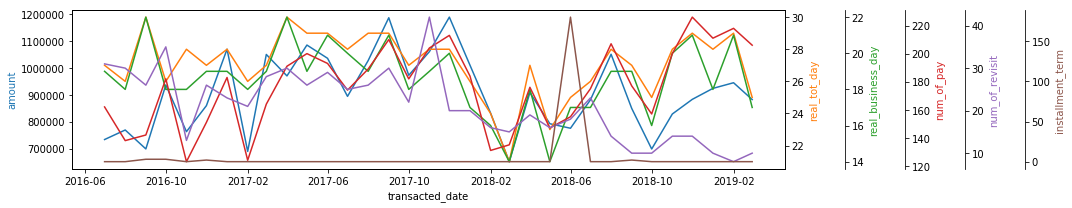

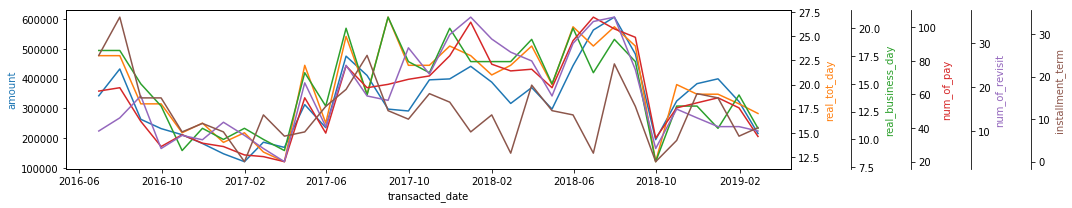

In [25]:
for i in df_month.store_id.unique()[:5]:
    plot_model_graph(df_month, i, 'transacted_date', ['amount', 'real_tot_day', 'real_business_day', 'num_of_pay', 'num_of_revisit', 'installment_term'])

# # Step3. Modeling - Time Series

# 1. Simple Moving Average

In [26]:
def make_sma_arr(window_num):
    ma_arr = np.array([])
    for i in df_month.store_id.unique():
        df_set = df_month[df_month.store_id == i]

        # 단순 이동 평균 : rolling(갯수).mean()
        ma_arr = np.concatenate((ma_arr, df_set.amount.rolling(window_num).mean().values))        
    return ma_arr

In [28]:
sma_month = df_month.copy()

sma_month.insert(7, 'amount_2ma', make_sma_arr(2))
sma_month.insert(8, 'amount_3ma', make_sma_arr(3))
sma_month.insert(9, 'amount_6ma', make_sma_arr(6))
sma_month

,store_id,real_tot_day,real_business_day,num_of_pay,num_of_revisit,installment_term,amount,amount_2ma,amount_3ma,amount_6ma
2016-06-30,0,25,17.00000,145.00000,77.00000,13.00000,747000.00000,nan,nan,nan
2016-07-31,0,26,16.00000,178.00000,105.00000,24.00000,1005000.00000,876000.00000,nan,nan
2016-08-31,0,24,16.00000,171.00000,97.00000,69.00000,871571.42857,938285.71429,874523.80952,nan
2016-09-30,0,25,19.00000,160.00000,103.00000,15.00000,897857.14286,884714.28571,924809.52381,nan
2016-10-31,0,26,16.00000,167.00000,115.00000,9.00000,835428.57143,866642.85714,868285.71429,nan
...,...,...,...,...,...,...,...,...,...,...
2018-10-31,2136,31,23.00000,338.00000,86.00000,0.00000,2012214.28571,2393964.28571,2003409.52381,2023240.47619
2018-11-30,2136,28,20.00000,356.00000,87.00000,0.00000,2135428.57143,2073821.42857,2307785.71429,2013407.14286
2018-12-31,2136,31,21.00000,403.00000,109.00000,0.00000,2427428.57143,2281428.57143,2191690.47619,2029145.23810
2019-01-31,2136,31,23.00000,297.00000,74.00000,3.00000,1873642.85714,2150535.71429,2145500.00000,2074454.76190


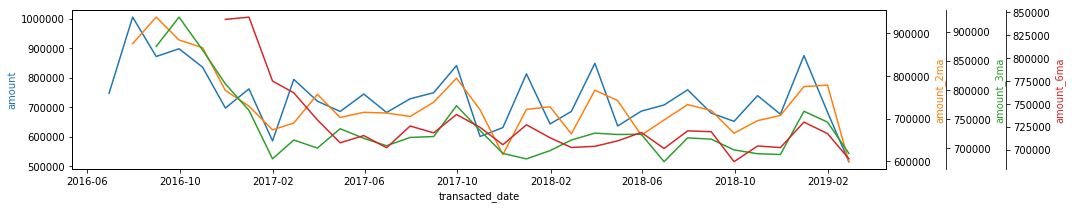

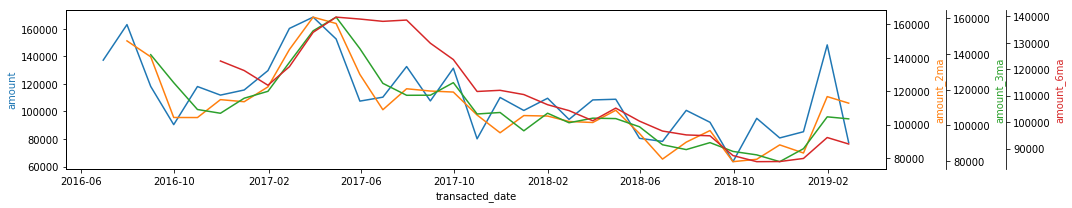

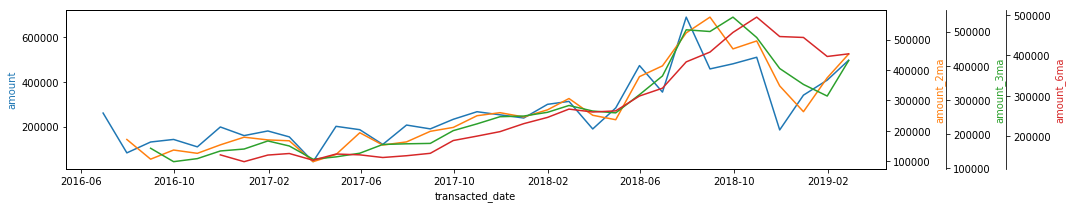

In [29]:
for i in sma_month.store_id.unique()[:3]:
    plot_model_graph(sma_month, i, 'transacted_date', ['amount', 'amount_2ma', 'amount_3ma', 'amount_6ma'])

In [30]:
print("2 winodw SMA MAE Score : ", mae(sma_month.amount_2ma.fillna(0), sma_month.amount.values))
print("3 window SMA MAE Score : ", mae(sma_month.amount_3ma.fillna(0), sma_month.amount.values))
print("6 window SMA MAE Score : ", mae(sma_month.amount_6ma.fillna(0), sma_month.amount.values))

2 winodw SMA MAE Score :  180687.25906004853
3 window SMA MAE Score :  251607.4552831229
6 window SMA MAE Score :  387465.0993765708


- rolling의 경우, window 3를 예를 들면 t 시점에 대한 값으로 t시점, t-1시점, t-2시점의 평균을 사용한다.
- 우리가 필요한 것은 t시점을 위해 t-1, t-2, t-3의 평균을 구하는 것이므로 함수를 생성하여 진행

In [31]:
def make_minus_rolling(data_frame, rolling_num):
    
    def minus_shift_rolling(df_num, num):
        # a : 첫달 예측
        a = np.average(df_num.values[-num:])
        # b : 둘째달 예측
        b = np.average(np.append(df_set.values[-(num-1):], a))
        
        if num > 2:
            c = np.average(np.append(np.append(df_set.values[-(num-2):], a), b))
        else:
            c = np.average((a, b))
        # a는 첫달, b는 둘째달, c는 셋째달
        return np.sum((a, b, c))

    minus_rolling_arr = np.array([])
    for i in data_frame.store_id.unique():
        df_set = pd.DataFrame(data_frame[data_frame.store_id == i].amount)
        minus_rolling_arr = np.concatenate((minus_rolling_arr, np.array([minus_shift_rolling(df_set, rolling_num)])))
       
    df_rolling = pd.DataFrame({'store_Id' : df_sub.store_id, 'amount' : minus_rolling_arr})
    
    return df_rolling

In [32]:
for i in range(2, 5):
    df_rolling = make_minus_rolling(df_month, i)
    df_rolling.to_csv('funda_{}_rolling_sub.csv'.format(i), index=False)

- SMA 2 rolling Score : 836184.506520
- SMA 3 rolling Score : 831158.397180
- SMA 4 rolling Score : 854300.339380

# 2. Exponential Moving Average

In [33]:
def make_ewm_arr(data_frame, span_num):
    arr_ewm = np.array([])
    for i in data_frame.store_id.unique():
        df_set = data_frame[data_frame.store_id == i]
        
        # 지수 이동 평균 : ewm(span=갯수).mean()
        arr_ewm = np.concatenate((arr_ewm, df_set.amount.ewm(span=span_num).mean().values))
    return arr_ewm

In [35]:
ewm_month = df_month.copy()

ewm_month.insert(7, 'amount_3ewm', make_ewm_arr(df_month, 3))
ewm_month.insert(8, 'amount_5ewm', make_ewm_arr(df_month, 5))
ewm_month.insert(9, 'amount_6ewm', make_ewm_arr(df_month, 6))
ewm_month.head(3)

,store_id,real_tot_day,real_business_day,num_of_pay,num_of_revisit,installment_term,amount,amount_3ewm,amount_5ewm,amount_6ewm
2016-06-30,0,25,17.00000,145.00000,77.00000,13.00000,747000.00000,747000.00000,747000.00000,747000.00000
2016-07-31,0,26,16.00000,178.00000,105.00000,24.00000,1005000.00000,919000.00000,901800.00000,897500.00000
2016-08-31,0,24,16.00000,171.00000,97.00000,69.00000,871571.42857,891897.95918,887481.20301,885844.03670


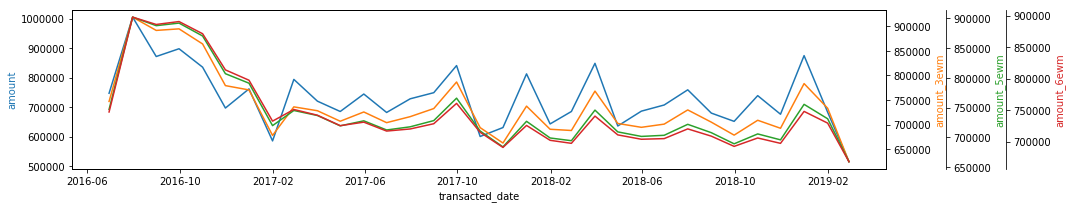

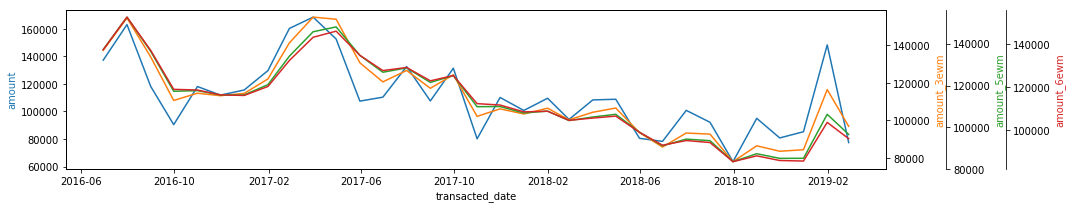

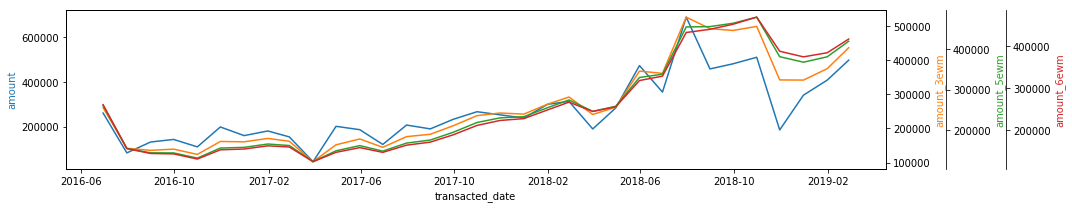

In [36]:
for i in ewm_month.store_id.unique()[:3]:
    plot_model_graph(ewm_month, i, 'transacted_date', ['amount', 'amount_3ewm', 'amount_5ewm', 'amount_6ewm'])

In [37]:
print("3 N EWM MAE Score : ", mae(ewm_month.amount_3ewm, sma_month.amount.values))
print("5 N EWM MAE Score : ", mae(ewm_month.amount_5ewm, sma_month.amount.values))
print("6 N EWM MAE Score : ", mae(ewm_month.amount_6ewm, sma_month.amount.values))

3 N EWM MAE Score :  134855.11946915492
5 N EWM MAE Score :  179788.3425985126
6 N EWM MAE Score :  193447.63093078104


- 3~7 Exponential Weighted Moving Score 확인

In [38]:
def make_wma_sub(data_frame, span_num):
    concat_3mon = pd.DataFrame(index=pd.to_datetime(['2019-03-31', '2019-04-30', '2019-05-31']))
    wma_sub = np.array([])

    for i in df_month.store_id.unique():
        df_set = pd.DataFrame(data_frame[data_frame.store_id == i].amount)
        # 비어있는 셀 만들어주기
        wma_train = pd.concat([df_set, concat_3mon], axis=0)
        
        # 세달 예측 후 합하기
        num_sub = np.array([wma_train.amount.ewm(span=span_num).mean()['2019-03':].sum()])
        wma_sub = np.concatenate((wma_sub, num_sub))
        
    df_wma_sub = pd.DataFrame({'store_id' : df_sub.store_id, 'amount' : wma_sub})
    return df_wma_sub

In [39]:
for i in range(2, 7):
    wma_sub = make_wma_sub(df_month, i)
    wma_sub.to_csv('funda_{}wma_sub.csv'.format(i), index=False)

- 2 span 제출 Score : 820102.106670
- 3 span 제출 Score : 785488.281930
- 4 span 제출 Score : 770667.895320
- 5 span 제출 Score : 767498.551420
- 6 span 제출 Score : 770414.027040

# 3. Exponential Smoothing (지수평활법 - Simple, Holt's, Holt-Winter's)
## 1) Simple Exponential Smoothing

In [40]:
df_set = df_month[df_month.store_id == 0]

size = int(len(df_set) * 0.7)
# train과 test로 나눠서 훈련
train = df_set[:size]
test = df_set[size:]

ses_model = SimpleExpSmoothing(train.amount)
ses_result = ses_model.fit()
ses_pred = ses_result.forecast(len(test))
ses_pred

C:\Users\user\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\user\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


2018-05-31   746938.72523
2018-06-30   746938.72523
2018-07-31   746938.72523
2018-08-31   746938.72523
2018-09-30   746938.72523
2018-10-31   746938.72523
2018-11-30   746938.72523
2018-12-31   746938.72523
2019-01-31   746938.72523
2019-02-28   746938.72523
Freq: M, dtype: float64

In [41]:
print("store_id 0 mean value : ", df_set.amount.mean())
print("MAE Score of test :", mae(test.amount, ses_pred))

store_id 0 mean value :  732559.7402597402
MAE Score of test : 77634.66370766224


In [42]:
def plot_train_test_pred_graph(trainset, testset, pred):
    plt.figure(figsize=(15,3))
    plt.plot(trainset.amount, label='train')
    plt.plot(testset.amount, label='test')
    plt.plot(testset.index, pred, label='prediction')
    plt.legend()
    plt.show()

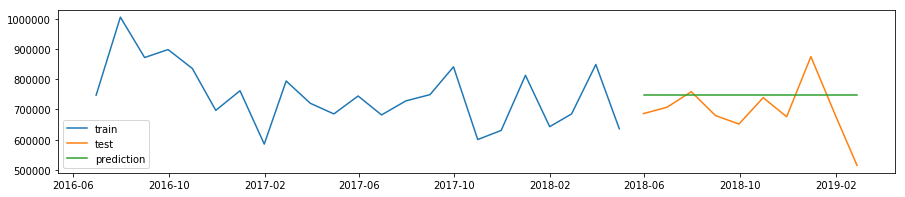

In [43]:
plot_train_test_pred_graph(train, test, ses_pred)

In [51]:
ses_pred_arr = np.array([])
for i in df_month.store_id.unique():
    df_set = df_month[df_month.store_id == i]
    
    ses_model = SimpleExpSmoothing(df_set.amount)
    ses_result = ses_model.fit()
    ses_pred = ses_result.forecast(3)
    
    ses_pred_arr = np.concatenate((ses_pred_arr, np.array([ses_pred.sum()])))

In [52]:
df_ses_sub = pd.DataFrame({'store_id' : df_sub.store_id, 'amount' : ses_pred_arr})

- Simple Exponential Smoothing Score : 818205.82245

## 2) Holt's Exponential Smoothing

In [44]:
df_set = df_month[df_month.store_id == 0]

size = int(len(df_set) * 0.7)
train = df_set[:size]
test = df_set[size:]

holt_model = Holt(np.array(train.amount))
holt_result = holt_model.fit()
holt_pred = holt_result.forecast(len(test))
holt_pred

C:\Users\user\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


array([695389.11834476, 676351.22618714, 657313.33402952, 638275.44187189,
       619237.54971427, 600199.65755665, 581161.76539902, 562123.8732414 ,
       543085.98108378, 524048.08892616])

Mean value of store_id 0 :  732559.7402597402
MAE Score of test : 91011.69496158164


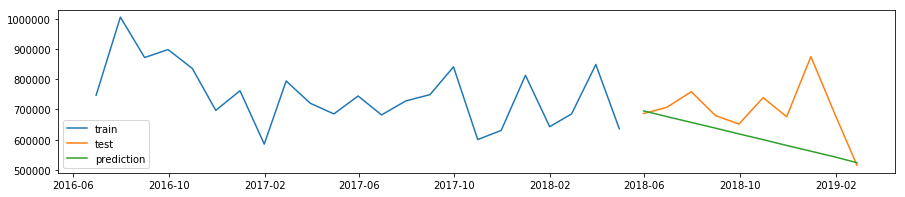

In [45]:
print("Mean value of store_id 0 : ", df_set.amount.mean())
print("MAE Score of test :", mae(test.amount, holt_pred))

plot_train_test_pred_graph(train, test, holt_pred)

In [49]:
%%time
holt_pred_arr = np.array([])
for i in df_month.store_id.unique():
    df_set = df_month[df_month.store_id == i]
    
    holt_model = Holt(np.array(df_set.amount))
    holt_result = holt_model.fit()
    holt_pred = holt_result.forecast(3)
    
    holt_pred_arr = np.concatenate((holt_pred_arr, np.array([holt_pred.sum()])))

In [50]:
holt_sub = pd.DataFrame({'sotre_id' : df_sub.store_id, 'amount' : holt_pred_arr})

- Holt's Exponential Smoothing Score : 926470.756080

## 3) Holt-Winter's Exponential Smoothing

In [46]:
df_set = df_month[df_month.store_id == 0]

size = int(len(df_set) * 0.7)
train = df_set[:size]
test = df_set[size:]

# 최적값을 찾기 위한 기준
es_score = 1000000000
best_period = 0
# 각 store_id 최적의 seasonal period를 찾기 위한 탐색
for p in range(2,(len(train)//2) + 1):
    try:
        # 가법 방법 사용
        es_model = ExponentialSmoothing(np.array(train.amount), seasonal_periods=p, trend='add', seasonal='add')
        es_result = es_model.fit()
        es_pred = es_result.forecast(len(test))

        if es_score > mae(test.amount, es_pred):
            es_score = mae(test.amount, es_pred)
            best_period = p
    except:
        continue

C:\Users\user\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
C:\Users\user\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
C:\Users\user\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
C:\Users\user\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
C:\Users\user\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
C:\Users\user\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:922: ConvergenceWarning: Optimi

Mean value of store_id 0 : 732559.7402597402
MAE Score of test : 65352.14301126023
Best seasonal period : 4


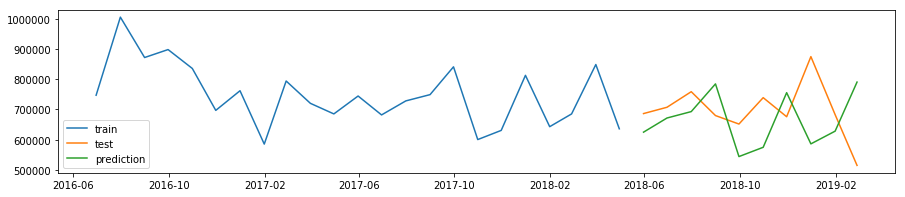

In [47]:
print("Mean value of store_id 0 :", df_set.amount.mean())
print("MAE Score of test :", es_score)
print("Best seasonal period :", best_period)

plot_train_test_pred_graph(train, test, es_pred)

In [52]:
%%time
holt_winters_arr = np.array([])
for i in df_month.store_id.unique():
    df_set = df_month[df_month.store_id == i]

    size = int(len(df_set) * 0.7)
    train = df_set[:size]
    test = df_set[size:]
    
    # 최적값을 찾기 위한 기준
    es_score = 1000000000
    best_period = 0
    # 각 store_id 최적의 seasonal period를 찾기 위한 탐색
    for p in range(2,(len(train)//2) + 1):
        try:
            es_model = ExponentialSmoothing(np.array(train.amount),seasonal_periods=p, trend='add', seasonal='add')
            es_result = es_model.fit()
            es_pred = es_result.forecast(len(test))

            if es_score > mae(test.amount, es_pred):
                es_score = mae(test.amount, es_pred)
                best_period = p
        except:
            continue
    
    # 최적의 parameter을 이용한 3개월 예측과 sum
    set_es_model = ExponentialSmoothing(np.array(df_set.amount), seasonal_periods=best_period, trend='add', seasonal='add')
    set_es_result = set_es_model.fit()
    set_es_pred = set_es_result.forecast(3)
    
    holt_winters_arr = np.concatenate((holt_winters_arr, np.array([set_es_pred.sum()])))

In [ ]:
holt_winters_sub = pd.DataFrame({'store_id' : df_sub.store_id, 'amount' : holt_winters_arr})
holt_winters_sub.to_csv('./__data/sub/funda_holt_winters_sub.csv', index=False)

- Holt-Winter's Exponential Smoothing Score : 962259.599880

In [48]:
# # amount에서 0이하 값 없앤다음에 한번 해보기 !
# from statsmodels.tsa.seasonal import seasonal_decompose

# ts = df_month.amount
# print(ts)
# result = seasonal_decompose(ts, model='multiplicative')

# plt.rcParams['figure.figsize'] = [12, 8]
# result.plot()
# plt.show()